# Time Series Chains

## Forecasting Web Query Data with Anchored Time Series Chains (ATSC)

This example is adapted from the [Web Query Volume case study](http://www.www2015.it/documents/proceedings/proceedings/p721.pdf) and utilizes the main takeaways from the [Matrix Profile VII](https://www.cs.ucr.edu/~eamonn/chains_ICDM.pdf) research paper.

## Getting Started

Let's import the packages that we'll need to load, analyze, and plot the data.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import stumpy
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch
import itertools

plt.style.use('stumpy.mplstyle')

## What are Time Series Chains?

Time series chains may be informally considered as motifs that evolve or drift in some direction over time. The figure below illustrates the difference
between [time series motifs](Tutorial_1.ipynb) (left) and time series chains (right).

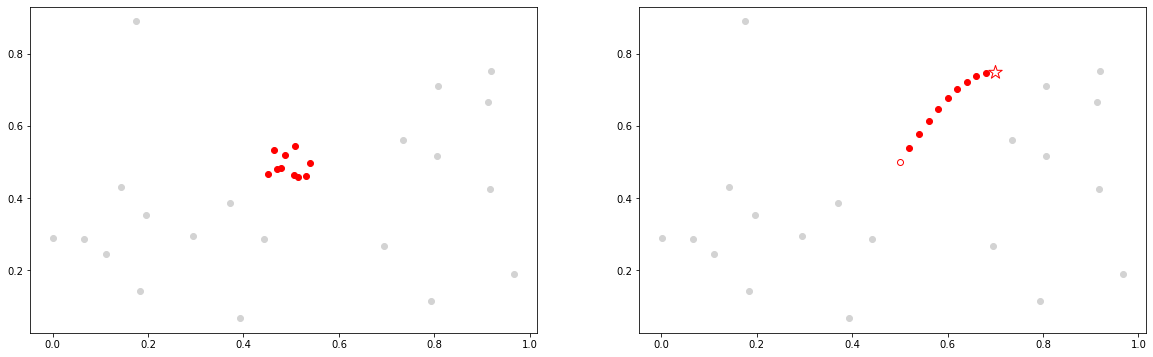

In [2]:
x = np.random.rand(20)
y = np.random.rand(20)
n = 10
motifs_x = 0.5 * np.ones(n) + np.random.uniform(-0.05, 0.05, n)
motifs_y = 0.5 * np.ones(n) + np.random.uniform(-0.05, 0.05, n)
sin_x = np.linspace(0, np.pi/2, n+1)
sin_y = np.sin(sin_x)/4
chains_x = 0.5 * np.ones(n+1) + 0.02 * np.arange(n+1)
chains_y = 0.5 * np.ones(n+1) + sin_y
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].scatter(x, y, color='lightgrey')
axes[0].scatter(motifs_x, motifs_y, color='red')
axes[1].scatter(x, y, color='lightgrey')
axes[1].scatter(chains_x[0], chains_y[0], edgecolor='red', color='white')
axes[1].scatter(chains_x[1:n], chains_y[1:n], color='red')
axes[1].scatter(chains_x[n], chains_y[n], edgecolor='red', color='white', marker='*', s=200)
plt.show()

Above, we are visualizing time series subsequences as points in high-dimensional space. Shown on the left is a time series motif and it can be thought of as a collection of points that approximate a platonic ideal. In contrast, depicted on the right, is a time series chain and it may be thought of as an evolving trail of points in the space. Here, the open red circle represents the first link in the chain, the anchor. Both motifs and chains have the property that each subsequence is relatively close to its nearest neighbor. However, the motif set (left) also has a relatively small diameter. In contrast, the set of points in a chain (right) has a diameter that is much larger than the mean of each member’s distance to its nearest neighbor and, moreover, the chain has the important property of <b>directionality</b>. For example, in the case of a motif, if an additional member was added to the motif set, its location will also be somewhere near the platonic ideal, but independent of the previous subsequences. In contrast, in the case of a chain, the location of the next member of the chain would be somewhere after the last red circle, possibly where the open red star is located.

## A Simplified Example

Adapted from the [Matrix Profile VII](https://www.cs.ucr.edu/~eamonn/chains_ICDM.pdf) paper,  consider the following time series:

47, 32, 1, 22, 2, 58, 3, 36, 4, -5, 5, 40

Assume that the subsequence length is 1 and the distance between two subsequences is simply the absolute difference
between them. To be clear, we are making these simple and pathological assumptions here just for the purposes of
elucidation; we are actually targeting much longer subsequence lengths and using z-normalized Euclidean distance in our
applications. To capture the directionality of a time series chain, we need to store the left and right nearest neighbor information into the left (IL) and right (IR) matrix profile indices:

| Index | Value | Left Index (IL) | Right Index (IR) |
|-------|-------|-----------------|------------------|
| 1     | 47    | -               | 12               |
| 2     | 32    | 1               | 8                |
| 3     | 1     | 2               | 5                |
| 4     | 22    | 2               | 8                |
| 5     | 2     | 3               | 7                |
| 6     | 58    | 1               | 12               |
| 7     | 3     | 5               | 9                |
| 8     | 36    | 2               | 12               |
| 9     | 4     | 7               | 11               |
| 10    | -5    | 3               | 11               |
| 11    | 5     | 9               | 12               |
| 12    | 40    | 8               | -                |

In this vertical/transposed representation, the `index` column shows the location of every subsequence in the time series, the `value` column contains the original numbers from our time series above, the `IL` column shows the left matrix profile indices, and `IR` is the right matrix profile indices. For example, `IR[2] = 8` means the right nearest neighbor of `index = 2` (which has `value = 32`) is at `index = 8` (which has `value = 36`). Similarly, `IL[3] = 2` means that the left nearest neighbor of `index = 3` (with `value = 1`) is at `index = 2` (which has `value = 32`). To better visualize the left/right matrix profile index, we use arrows to link every subsequence in the time series with its left and right nearest neighbors:

<ipython-input-3-105203bdfa7f>:32: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(xs, ys, "-o", markerfacecolor="None", markeredgecolor="None", linestyle="None")


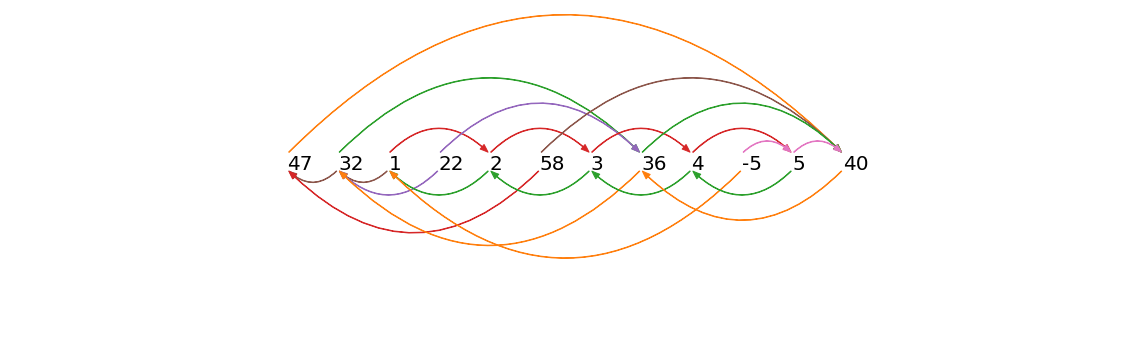

In [3]:
nearest_neighbors = np.array([[1,  47, np.nan,     12],
                              [2,  32,      1,      8],
                              [3,   1,      2,      5],
                              [4,  22,      2,      8],
                              [5,   2,      3,      7],
                              [6,  58,      1,     12],
                              [7,   3,      5,      9],
                              [8,  36,      2,     12],
                              [9,   4,      7,     11],
                              [10, -5,      3,     11],
                              [11,  5,      9,     12],
                              [12, 40,      8, np.nan]])

colors = [['C1', 'C1'],
          ['C2', 'C5'],
          ['C3', 'C5'],
          ['C4', 'C4'],
          ['C3', 'C2'],
          ['C5', 'C3'],
          ['C3', 'C2'],
          ['C2', 'C1'],
          ['C3', 'C2'],
          ['C6', 'C1'],
          ['C6', 'C2'],
          ['C1', 'C1']]

style="Simple, tail_width=0.5, head_width=6, head_length=8"
kw = dict(arrowstyle=style, connectionstyle="arc3, rad=-.5",)

xs = np.arange(nearest_neighbors.shape[0]) + 1
ys = np.zeros(nearest_neighbors.shape[0])
plt.plot(xs, ys, "-o", markerfacecolor="None", markeredgecolor="None", linestyle="None")

x0, x1, y0, y1 = plt.axis()
plot_margin = 5.0
plt.axis((x0 - plot_margin,
          x1 + plot_margin,
          y0 - plot_margin,
          y1 + plot_margin))
plt.axis('off')

for x, y, nearest_neighbor, color in zip(xs, ys, nearest_neighbors, colors):
    plt.text(x, y, str(int(nearest_neighbor[1])), color="black", fontsize=20)
    
    # Plot right matrix profile indices
    if not np.isnan(nearest_neighbor[3]):
        arrow = FancyArrowPatch((x, 0.5), (nearest_neighbor[3], 0.5), color=color[0], **kw)
        plt.gca().add_patch(arrow)
        
    # Plot left matrix profile indices
    if not np.isnan(nearest_neighbor[2]):
        arrow = FancyArrowPatch((x, 0.0), (nearest_neighbor[2], 0.0), color=color[1], **kw)
        plt.gca().add_patch(arrow)

plt.show()

An arrow pointing from a number to its right nearest neighbor (arrows shown above the time series) can be referred to as forward arrow and an arrow pointing from a number to its left nearest neighbor (arrows shown below the time series) can be referred to as a backward arrow. According to the formal definition of a time series chain (see [Matrix Profile VII](https://www.cs.ucr.edu/~eamonn/chains_ICDM.pdf) for a thorough definition and discussion), every pair of consecutive subsequences in a chain must be connected by both a forward arrow and a backward arrow. A keen eye will spot the fact that the longest chain in our simplified example is:

<ipython-input-4-b09fcbf8ba29>:32: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(xs, ys, "-o", markerfacecolor="None", markeredgecolor="None", linestyle="None")


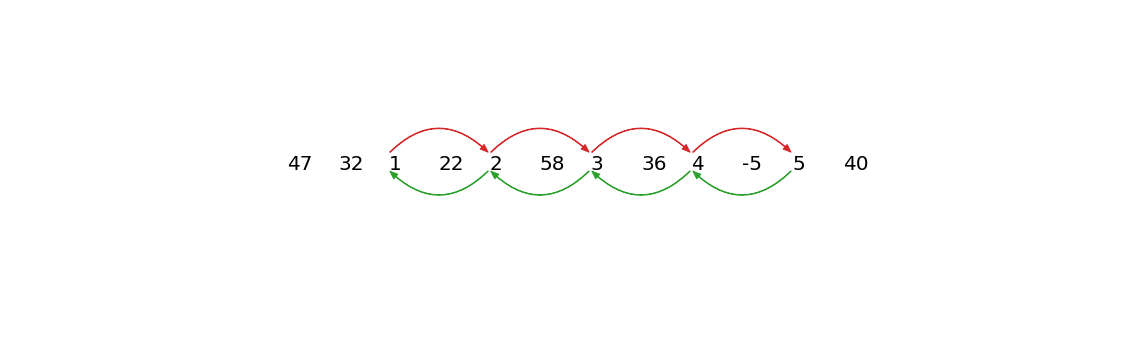

In [4]:
nearest_neighbors = np.array([[1,  47, np.nan, np.nan],
                              [2,  32, np.nan, np.nan],
                              [3,   1, np.nan,      5],
                              [4,  22, np.nan, np.nan],
                              [5,   2,      3,      7],
                              [6,  58, np.nan, np.nan],
                              [7,   3,      5,      9],
                              [8,  36, np.nan, np.nan],
                              [9,   4,      7,     11],
                              [10, -5, np.nan, np.nan],
                              [11,  5,      9, np.nan],
                              [12, 40, np.nan, np.nan]])

colors = [['C1', 'C1'],
          ['C2', 'C5'],
          ['C3', 'C5'],
          ['C4', 'C4'],
          ['C3', 'C2'],
          ['C5', 'C3'],
          ['C3', 'C2'],
          ['C2', 'C1'],
          ['C3', 'C2'],
          ['C6', 'C1'],
          ['C6', 'C2'],
          ['C1', 'C1']]

style="Simple, tail_width=0.5, head_width=6, head_length=8"
kw = dict(arrowstyle=style, connectionstyle="arc3, rad=-.5",)

xs = np.arange(nearest_neighbors.shape[0]) + 1
ys = np.zeros(nearest_neighbors.shape[0])
plt.plot(xs, ys, "-o", markerfacecolor="None", markeredgecolor="None", linestyle="None")

x0, x1, y0, y1 = plt.axis()
plot_margin = 5.0
plt.axis((x0 - plot_margin,
          x1 + plot_margin,
          y0 - plot_margin,
          y1 + plot_margin))
plt.axis('off')

for x, y, nearest_neighbor, color in zip(xs, ys, nearest_neighbors, colors):
    plt.text(x, y, str(int(nearest_neighbor[1])), color="black", fontsize=20)
    
    # Plot right matrix profile indices
    if not np.isnan(nearest_neighbor[3]):
        arrow = FancyArrowPatch((x, 0.5), (nearest_neighbor[3], 0.5), color=color[0], **kw)
        plt.gca().add_patch(arrow)
        
    # Plot left matrix profile indices
    if not np.isnan(nearest_neighbor[2]):
        arrow = FancyArrowPatch((x, 0.0), (nearest_neighbor[2], 0.0), color=color[1], **kw)
        plt.gca().add_patch(arrow)

plt.show()

The longest extracted chain is therefore 1 ⇌ 2 ⇌ 3 ⇌ 4 ⇌ 5. Note that we see a gradual monotonic increase in the data but, in reality, the increase or decrease in drift can happen in arbitrarily complex ways that can be detected by the time series chains approach. The key component of drifting is that the time series must contain chains with clear directionality.

STUMPY is capable of computing:

1. anchored time series chains (ATSC) - grow a chain from a user-specified anchor (i.e., specific subsequence)
2. all-chain set (ALLC) - a set of anchored time series chains (i.e., each chain starts with a particular subsequence) that are not subsumed by another longer chain
3. unanchored time series chain(s) - the unconditionally longest chain within a time series (there could be more than one if there were chains with the same length) 

So, what does this mean in the context of a real time series? Let's take a look at a real example from web query data!

## Retrieve the Data

We will be looking at a noisy dataset that is under-sampled and has a growing trend, which will perfectly illustrate the idea regarding time series chains. The data contains a decade-long GoogleTrend query volume (collected weekly from 2004-2014) for the keyword Kohl’s, an American retail chain. First, we'll download the data, extract it, and insert it into a pandas dataframe.

In [5]:
df = pd.read_csv("https://zenodo.org/record/4276348/files/Time_Series_Chains_Kohls_data.csv?download=1")
df.head()

,volume
0,0.010417
1,0.010417
2,0.010417
3,0.000000
4,0.000000


## Visualizing the Data

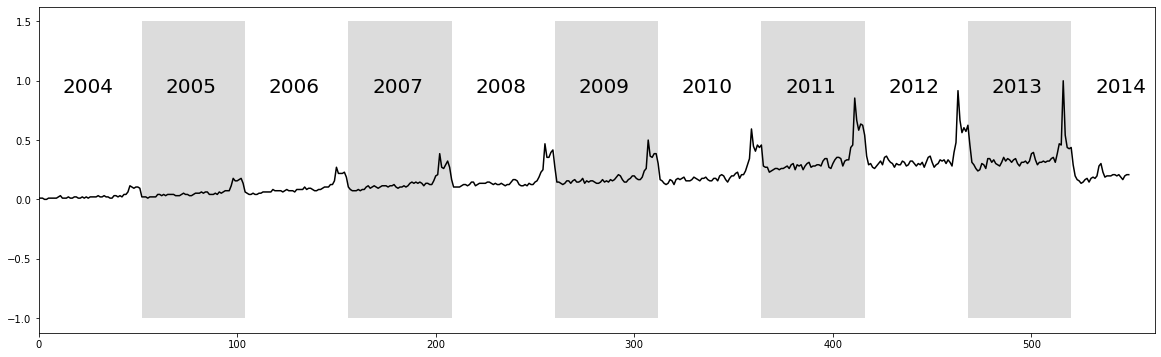

In [6]:
plt.plot(df['volume'], color='black')
plt.xlim(0, df.shape[0]+12)
color = itertools.cycle(['white', 'gainsboro'])
for i, x in enumerate(range(0, df.shape[0], 52)):
    plt.text(x+12, 0.9, str(2004+i), color="black", fontsize=20)
    rect = Rectangle((x, -1), 52, 2.5, facecolor=next(color))
    plt.gca().add_patch(rect)
plt.show()

The raw time series above displays ten years of web query volume for the keyword "Kohl's", where each alternating white and grey vertical band represents a 52 week period starting from 2004 to 2014. As depicted, the time series features a significant but unsurprising "end-of-year holiday bump". Relating back to time series chains, we can see that the bump is generally increasing over time and so we might be able to capture this when we compute the unanchored chain.

However, as we learned above, in order to compute any time series chains, we also need the left and right matrix profile indices. Luckily for us, according to the docstring, the `stump` function not only returns the (bidirectional) matrix profile and the matrix profile indices in the first and second columns of the NumPy array, respectively, but the third and fourth columns consists of the left matrix profile indices and the right matrix profile indices, respectively.

## Computing the Left and Right Matrix Profile Indices

So, let's go ahead and compute the matrix profile indices and we'll set the window size, `m = 20`, which is the approximate length of a "bump".

In [7]:
m = 20
mp = stumpy.stump(df['volume'], m=m)

## Computing the Unanchored Chain

Now, with our left and right matrix profile indices in hand, we are ready to call the all-chain set function, `allc`, which not only returns the all-chain set but, as a freebie, it also returns the unconditionally longest chain, also know as the unanchored chain. The latter of which is really what we're most interested in.

In [8]:
all_chain_set, unanchored_chain = stumpy.allc(mp[:, 2], mp[:, 3])

## Visualizing the Unanchored Chain

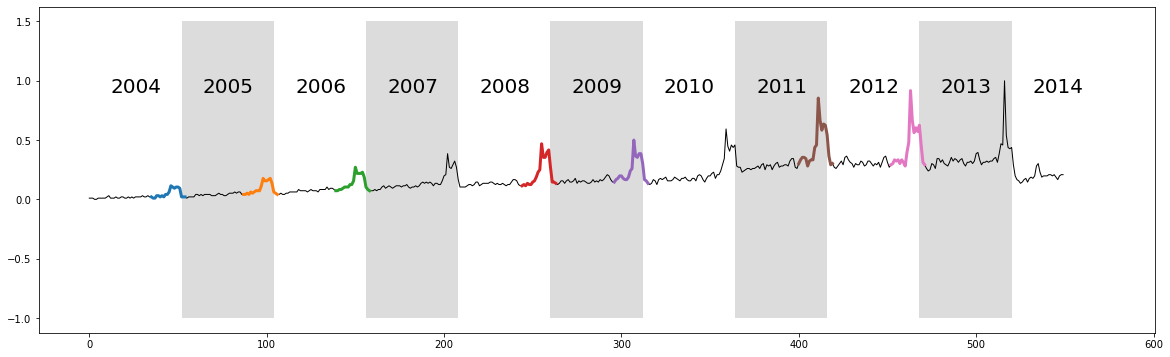

In [9]:
plt.plot(df['volume'], linewidth=1, color='black')
for i in range(unanchored_chain.shape[0]):
    y = df['volume'].iloc[unanchored_chain[i]:unanchored_chain[i]+m]
    x = y.index.values
    plt.plot(x, y, linewidth=3)
color = itertools.cycle(['white', 'gainsboro'])
for i, x in enumerate(range(0, df.shape[0], 52)):
    plt.text(x+12, 0.9, str(2004+i), color="black", fontsize=20)
    rect = Rectangle((x, -1), 52, 2.5, facecolor=next(color))
    plt.gca().add_patch(rect)

plt.show()

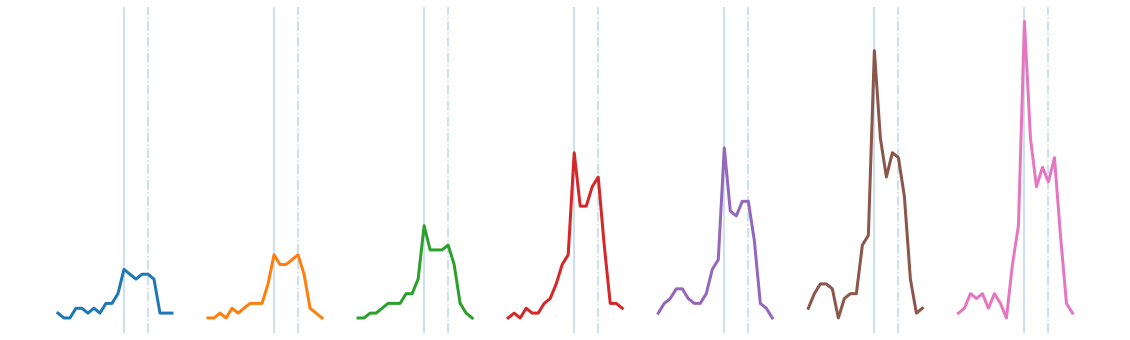

In [10]:
plt.axis('off')
for i in range(unanchored_chain.shape[0]):
    data = df['volume'].iloc[unanchored_chain[i]:unanchored_chain[i]+m].reset_index().values
    x = data[:, 0]
    y = data[:, 1]
    plt.axvline(x=x[0]-x.min()+(m+5)*i + 11, alpha=0.3)
    plt.axvline(x=x[0]-x.min()+(m+5)*i + 15, alpha=0.3, linestyle='-.')
    plt.plot(x-x.min()+(m+5)*i, y-y.min(), linewidth=3)
plt.show()

The discovered chain shows that over the decade, the bump transitions from a smooth bump covering the period between Thanksgiving (solid vertical line) and Christmas (dashed vertical line), to a more sharply focused bump centered on Thanksgiving. This seems to reflect the growing importance of "Cyber Monday", a marketing term for the Monday after Thanksgiving. The phrase was created by marketing companies to persuade consumers to shop online. The term made its debut on November 28th, 2005 in a press release entitled “Cyber Monday Quickly Becoming One of the Biggest Online Shopping Days of the Year”. Note that this date coincides with the first glimpse of the sharpening peak in our chain.

It also appears that we may have “missed” a few links in the chain. However, note that the data is noisy and undersampled, and the “missed” bumps are too distorted to conform with the general evolving trend. This noisy example actually illustrates the robustness of the time series chains technique. As noted before, we don't
actually need “perfect” data in order to find meaningful chains. Even if some links are badly distorted, the discovered chain will still be able to include all of the other evolving patterns.

One final consideration is the potential use of chains to predict the future. One could leverage the evolving links within the chains in order to forecast the shape of the next bump. We refer the reader to the [Matrix Profile VII](https://www.cs.ucr.edu/~eamonn/chains_ICDM.pdf) for further discussions on this topic.

## Summary

And that's it! You've just learned the basics of how to identify directional trends, also known as chains, within your data using the matrix profile indices and leveraging `allc`.

## Resources

[Matrix Profile VII](https://www.cs.ucr.edu/~eamonn/chains_ICDM.pdf)


[Matrix Profile VII Supplementary Materials](https://sites.google.com/site/timeserieschain/)

[STUMPY Documentation](https://stumpy.readthedocs.io/en/latest/)

[STUMPY Matrix Profile Github Code Repository](https://github.com/TDAmeritrade/stumpy)